In [ ]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [ ]:
from datetime import datetime
from packaging import version

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""# Importing Libraries"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import interp1d
from scipy.stats import kurtosis
from scipy.stats import skew
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from scipy.ndimage import zoom
from skimage.measure import block_reduce
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.optimizers import Adam
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from keras.layers.core import Reshape
from keras.layers import LSTM
from keras import regularizers

In [ ]:
import tensorboard
tensorboard.__version__


'2.12.1'

In [ ]:
# Clear any logs from previous runs
rm -rf ./logs/

SyntaxError: invalid syntax (335981479.py, line 2)

In [ ]:
"""# Loading Data"""

path = "drive/MyDrive/Cog_DataSets/testing/"
# path = "drive/MyDrive/Colab Notebooks/CogAge/Datasets/testing/"
test_acc = np.load(path+"testAccelerometer.npy")
test_grav = np.load(path+"testGravity.npy")
test_gyro = np.load(path+"testGyroscope.npy")
test_jinsAcc = np.load(path+"testJinsAccelerometer.npy")
test_jinsGyro = np.load(path+"testJinsGyroscope.npy")
test_Label =np.load(path+"testLabels.npy") 
test_linAcc = np.load(path+"testLinearAcceleration.npy")
test_MsAcc = np.load(path+"testMSAccelerometer.npy")
test_MsGyro = np.load(path + "testMSGyroscope.npy")
test_MsMag = np.load(path+"testMagnetometer.npy")
# test_acc

path = "drive/MyDrive/Cog_DataSets/training/"
# path = "drive/MyDrive/Colab Notebooks/CogAge/Datasets/training/"
train_acc = np.load(path+"trainAccelerometer.npy")
train_grav = np.load(path+"trainGravity.npy")
train_gyro = np.load(path+"trainGyroscope.npy")
train_jinsAcc = np.load(path+"trainJinsAccelerometer.npy")
train_jinsGyro = np.load(path+"trainJinsGyroscope.npy")
train_Label =np.load(path+"trainLabels.npy") 
train_linAcc = np.load(path+"trainLinearAcceleration.npy")
train_MsAcc = np.load(path+"trainMSAccelerometer.npy")
train_MsGyro = np.load(path + "trainMSGyroscope.npy")
train_MsMag = np.load(path+"trainMagnetometer.npy")
# print(train_Label.shape)

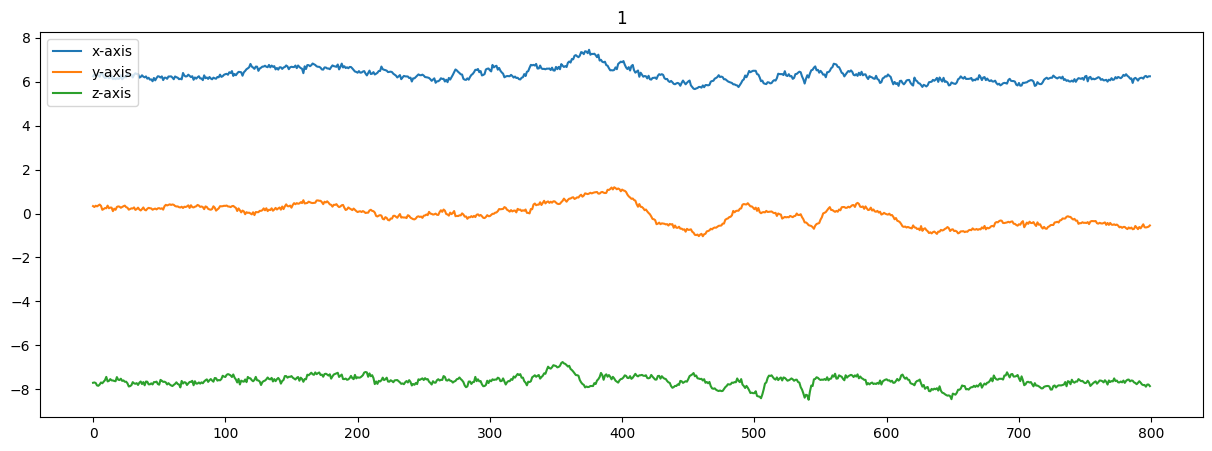

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
axs.plot(train_acc[100][:])
plt.legend(['x-axis', 'y-axis', 'z-axis'], loc="upper left")
plt.title(train_Label[100])
# axs[1].plot(train_MsAcc[0][:])
# plt.legend(['x-axis', 'y-axis', 'z-axis'], loc="upper left")
# axs[2].plot(train_jinsAcc[0][:])
# plt.legend(['x-axis', 'y-axis', 'z-axis'], loc="upper left")
plt.show()

In [ ]:
"""# Reshape and stack Data Before Fitting to Model"""
# changing shape of sensor data to (#,400,3)
# downsample
train_acc_reshaped = block_reduce(train_acc, block_size=(1, 2, 1), func=np.mean)
train_gyro_reshaped = block_reduce(train_gyro, block_size=(1, 2, 1), func=np.mean)
train_grav_reshaped = block_reduce(train_grav, block_size=(1, 2, 1), func=np.mean)
train_linAcc_reshaped = block_reduce(train_linAcc, block_size=(1, 2, 1), func=np.mean)
# upsample
train_MsAcc_reshaped = resize(train_MsAcc, (2284, 400, 3), mode='edge')
train_MsGyro_reshaped = resize(train_MsGyro, (2284, 400, 3), mode='edge')
# upsample
train_MsMag_reshaped = np.repeat(train_MsMag, 2, axis=1)
train_jinsAcc_reshaped = np.repeat(train_jinsAcc, 5, axis=1)
train_jinsGyro_reshaped = np.repeat(train_jinsGyro, 5, axis=1)

test_acc_reshaped = block_reduce(test_acc, block_size=(1, 2, 1), func=np.mean)
test_gyro_reshaped = block_reduce(test_gyro, block_size=(1, 2, 1), func=np.mean)
test_grav_reshaped = block_reduce(test_grav, block_size=(1, 2, 1), func=np.mean)
test_linAcc_reshaped = block_reduce(test_linAcc, block_size=(1, 2, 1), func=np.mean)
test_MsAcc_reshaped = resize(test_MsAcc, (2288, 400, 3), mode='edge')
test_MsGyro_reshaped = resize(test_MsGyro, (2288, 400, 3), mode='edge')
test_MsMag_reshaped = np.repeat(test_MsMag, 2, axis=1)
test_jinsAcc_reshaped = np.repeat(test_jinsAcc, 5, axis=1)
test_jinsGyro_reshaped = np.repeat(test_jinsGyro, 5, axis=1)

In [ ]:
# all data of shape #,400,3
# adding all relative data.
# Mobile training accelerometer + Mobile testing accelerometer data
train_acc_reshaped = np.append(train_acc_reshaped,test_acc_reshaped, axis=0)
train_gyro_reshaped = np.append(train_gyro_reshaped,test_gyro_reshaped, axis=0)
train_grav_reshaped = np.append(train_grav_reshaped,test_grav_reshaped, axis=0)
train_linAcc_reshaped = np.append(train_linAcc_reshaped,test_linAcc_reshaped, axis=0)
train_MsAcc_reshaped = np.append(train_MsAcc_reshaped,test_MsAcc_reshaped, axis=0)
train_MsGyro_reshaped = np.append(train_MsGyro_reshaped,test_MsGyro_reshaped, axis=0)
train_MsMag_reshaped = np.append(train_MsMag_reshaped,test_MsMag_reshaped, axis=0)
train_jinsAcc_reshaped = np.append(train_jinsAcc_reshaped,test_jinsAcc_reshaped, axis=0)
train_jinsGyro_reshaped = np.append(train_jinsGyro_reshaped,test_jinsGyro_reshaped, axis=0)


# print("Shape of all sensors after up/down sample... ", train_acc_reshaped.shape, train_gyro_reshaped.shape, train_grav_reshaped.shape, train_linAcc_reshaped.shape
#                        , train_MsAcc_reshaped.shape, train_MsGyro_reshaped.shape, train_MsMag_reshaped.shape,
#                        train_jinsAcc_reshaped.shape, train_jinsGyro_reshaped.shape)

# all data of shape 4572,400,3
# 4572 = 2284(training) + 2288(testing)


# stack
all_data = np.stack([train_acc_reshaped, train_gyro_reshaped, train_grav_reshaped, train_linAcc_reshaped
                       , train_MsAcc_reshaped, train_MsGyro_reshaped, train_MsMag_reshaped,
                       train_jinsAcc_reshaped, train_jinsGyro_reshaped], axis=-1)

all_Label = np.append(train_Label, test_Label, axis=-1)
print(all_data.shape)

(4572, 400, 3, 9)


In [ ]:
# 90% training data + labels
train_data = all_data[: int(all_data.shape[0]*0.6)]
# 10% testing data + labels
test_data = all_data[int(all_data.shape[0]*0.6):]
train_labels = all_Label[: int(all_Label.shape[0]*0.6)]
test_labels = all_Label[int(all_Label.shape[0]*0.6):]

print("\nShape of training and testin data + labels...\n")
print(train_data.shape, test_data.shape)
print(train_labels.shape, test_labels.shape)


# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.2, random_state=33)

print("Shape of training + validation Data")
print(np.shape(x_train), np.shape(y_train))

y_train = to_categorical(y_train, num_classes=55)
y_val = to_categorical(y_val, num_classes=55)

print("Shape of training + validation Labels")
print(np.shape(y_train), np.shape(y_val))



Shape of training and testin data + labels...

(2743, 400, 3, 9) (1829, 400, 3, 9)
(2743,) (1829,)
Shape of training + validation Data
(2194, 400, 3, 9) (2194,)
Shape of training + validation Labels
(2194, 55) (549, 55)


In [ ]:
# HYPER PARAMTERS

# Activation function of the convolutional layer(s)
activationConv = 'relu'

# Output dimension of the LSTM
outputLSTM = 100

# Parameters of the dense layer
activationMLP = 'relu'
inputMLP = 4500

# Training parameters
batchSize = 320
numberOfEpochs = 30
learningRate = 0.001

input_shape = (400,3,9)
nbClasses = 55
timeWindow = 400
nbSensors = 9

In [ ]:
#-------------------------------------------------------------------------------------------------------
# normLstm: define a batch normalization + LSTM DNN
#-------------------------------------------------------------------------------------------------------
def normLstm(
    inputShape,
    timeWindow,
    nbSensors,
    outputLSTM,
    inputMLP,
    activationMLP,
    nbClasses,
    withSoftmax=True):

    model = Sequential()
    nbFeaturePerSensor = 3

    # Batch normalization layer
    model.add(BatchNormalization(input_shape=inputShape))

    # LSTM layer with a many-to-one implementation
    # Note: size of the output = (outputSizeLastConv, outputLSTM)
    model.add(Reshape((timeWindow, nbSensors * nbFeaturePerSensor)))
    model.add(LSTM(outputLSTM, return_sequences=True,kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.3))
    model.add(LSTM(outputLSTM, return_sequences=False,kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))

    # Fully-connected layer with regularization
    model.add(Dense(inputMLP, activation=activationMLP))

    # Dropout layer
    model.add(Dropout(0.2))

    # # Additional regularization layers
    # model.add(Dense(inputMLP, activation=activationMLP, kernel_regularizer=regularizers.l2(0.001)))
    # model.add(Dropout(0.2))

    # Softmax layer
    if withSoftmax:
        model.add(Dense(nbClasses, activation='softmax'))
        
    return model

In [ ]:
model = normLstm(inputShape=input_shape,
                     timeWindow=timeWindow,
                     nbSensors=nbSensors,
                     outputLSTM=outputLSTM,
                     inputMLP=inputMLP,
                     activationMLP=activationMLP,
                     nbClasses=nbClasses)



model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=learningRate),
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 400, 3, 9)        36        
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 400, 27)           0         
                                                                 
 lstm (LSTM)                 (None, 400, 150)          106800    
                                                                 
 dropout (Dropout)           (None, 400, 150)          0         
                                                                 
 lstm_1 (LSTM)               (None, 150)               180600    
                                                                 
 dropout_1 (Dropout)         (None, 150)               0         
                                                        

In [ ]:
# Define the Keras TensorBoard callback.
# logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=30,
    batch_size=batchSize,
    # callbacks=[tensorboard_callback]
)

Epoch 1/30
7/7 [==============================] - 36s 5s/step - loss: 0.7828 - accuracy: 0.8432 - val_loss: 2.6009 - val_accuracy: 0.5774
Epoch 2/30
7/7 [==============================] - 33s 5s/step - loss: 0.7760 - accuracy: 0.8500 - val_loss: 2.5687 - val_accuracy: 0.5683
Epoch 3/30
7/7 [==============================] - 36s 5s/step - loss: 0.7673 - accuracy: 0.8523 - val_loss: 2.5827 - val_accuracy: 0.5811
Epoch 4/30
7/7 [==============================] - 38s 6s/step - loss: 0.8032 - accuracy: 0.8332 - val_loss: 2.5804 - val_accuracy: 0.5665
Epoch 5/30
7/7 [==============================] - 37s 5s/step - loss: 0.7415 - accuracy: 0.8573 - val_loss: 2.6601 - val_accuracy: 0.5792
Epoch 6/30
7/7 [==============================] - 33s 5s/step - loss: 0.7489 - accuracy: 0.8491 - val_loss: 2.6114 - val_accuracy: 0.6138
Epoch 7/30
7/7 [==============================] - 36s 5s/step - loss: 0.7499 - accuracy: 0.8482 - val_loss: 2.5941 - val_accuracy: 0.6102
Epoch 8/30
7/7 [==================

In [ ]:
%tensorboard --logdir logs


In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# plot the graph
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
estimatedLabels = np.argmax(model.predict(test_data),axis=-1)
estimatedLabels = estimatedLabels.flatten()

accuracy = accuracy_score(test_labels,estimatedLabels)
weightedF1 = f1_score(test_labels,estimatedLabels,average='weighted')
averageF1 = f1_score(test_labels,estimatedLabels,average='macro')
#confMat = confusion_matrix(testingLabels,estimatedLabels,labels=labelsTable.values())
allF1Scores = f1_score(test_labels,estimatedLabels,average=None)

# Print results
print('   Test accuracy = %.2f %%' % (accuracy*100))
print('   Weighted F1-score = %.4f' % (weightedF1))
print('   Average F1-score = %.4f' % (averageF1))
# print('   All F1-scores:')
# print(allF1Scores)
print('-------------------------------------------------------')

58/58 [==============================] - 12s 200ms/step
   Test accuracy = 51.23 %
   Weighted F1-score = 0.5109
   Average F1-score = 0.5077
-------------------------------------------------------
